In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import scipy
import math
from typing import List, Tuple, Dict, Union
from textwrap import wrap
import ipywidgets as widgets
from IPython.display import Markdown
from statsmodels.sandbox.stats.multicomp import multipletests
import os

pd.set_option('display.max_columns', None)

# Specialized High Schools and the SHSAT

According to a directory that the New York City Department of Education provides <sup><a href='#1'>1</a></sup> , NYC has 440 public high schools. 

In [19]:
HSDir_2017 = pd.read_csv('../data/2017-doe-high-school-directory.csv')
len(HSDir_2017['school_name'].unique())

440

Nine of these high schools are classified as "specialized" and are targeted specifically towards gifted students. 

In [20]:
#Creating a dictionary of specialized high schools and their district borough numbers, a helpful ID variable
specialized_dict = {dbn:school for dbn, school in HSDir_2017.query('specialized==1')[['dbn', 'school_name']].values}

for school in specialized_dict.values():
    print(school)

Brooklyn Latin School, The
Brooklyn Technical High School
Queens High School for the Sciences at York College
Fiorello H. LaGuardia High School of Music & Art and Performing Arts
Stuyvesant High School
High School for Mathematics, Science and Engineering at City College (HSMSE)
Staten Island Technical High School
Bronx High School of Science
High School of American Studies at Lehman College


The only criteria for admission to most specialized high schools is a student's score on the Specialized High Schools Admissions Test (SHSAT), a test consisting of an English Language Arts section and a math section. The only specialized high school that does not consider the SHSAT is Fiorello H. LaGuardia High School of Music & Art and Performing Arts. According to its website:
>"Acceptance to LaGuardia Arts is based on a competitive audition and review of student records to ensure success in both the demanding studio work and the challenging academic programs." <sup><a href='#2'>2</a></sup>

In [21]:
#Removing Fiorello from the specialized high school dictionary
specialized_dict.pop('03M485', None)

'Fiorello H. LaGuardia High School of Music & Art and Performing Arts'

The SHSAT is optionally offered every fall for 8th and 9th graders. Only 18% of the students who took the SHSAT in 2016 ended up receiving an offer, making these schools notoriously difficult to get into. <sup><a href='#3'>3</a></sup> 
 
 PASSNYC (Promoting Access to Specialized Schools in New York City) is a non-profit company based in NYC. Their purpose is to provide outreach programs for kids in under-served areas to help them prepare for the SHSAT. By giving the kids opportunities to succeed, PASSNYC aims to bring more diversity to the specialized high schools. The organization already has methods in place to identify kids and schools suited for their outreach programs. But they believe that they can do better.

 The purpose of this notebook is to quantify the diversity issue in specialized high schools. In a following notebook, schools that PASSNYC could help will be identified. 


# Disparity in the Specialized High Schools

On PASSNYC's website, they state: 
>"In recent years, the City’s specialized high schools—institutions with historically transformative impact on student outcomes—have seen a shift toward more homogenous [sic] student body demographics." <sup><a href='#4'>4</a></sup>

To validify this statement, demographic data is needed from a range of school years. Thankfully, a NYC Department of Education dataset labeled "2013 - 2018 Demographic Snapshot School" contains demographic information for students from 2013-2018. <sup><a href='#5'>5</a></sup> 

In [22]:
#Import the datasets
demographics_df = pd.read_csv('../data/2013_-_2018_Demographic_Snapshot_School.csv')

In [23]:
demographics_df.head()

,DBN,School Name,Year,Total Enrollment,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,# Female,% Female,# Male,% Male,# Asian,% Asian,# Black,% Black,# Hispanic,% Hispanic,# Multiple Race Categories Not Represented,% Multiple Race Categories Not Represented,# White,% White,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
0,01M015,P.S. 015 Roberto Clemente,2013-14,190,26,39,39,21,16,26,23,0,0,0,0,0,0,0,93,48.9%,97,51.1%,9,4.7%,72,37.9%,104,54.7%,2,1.1%,3,1.6%,65,34.2%,19,10%,171,90%,No Data
1,01M015,P.S. 015 Roberto Clemente,2014-15,183,18,27,47,31,19,17,24,0,0,0,0,0,0,0,84,45.9%,99,54.1%,8,4.4%,65,35.5%,107,58.5%,1,0.5%,2,1.1%,64,35%,17,9.3%,169,92.3%,93.5%
2,01M015,P.S. 015 Roberto Clemente,2015-16,176,14,32,33,39,23,17,18,0,0,0,0,0,0,0,83,47.2%,93,52.8%,9,5.1%,57,32.4%,105,59.7%,3,1.7%,2,1.1%,60,34.1%,16,9.1%,149,84.7%,89.6%
3,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,18,0,0,0,0,0,0,0,83,46.6%,95,53.4%,14,7.9%,51,28.7%,105,59%,4,2.2%,4,2.2%,51,28.7%,12,6.7%,152,85.4%,89.2%
4,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,26,0,0,0,0,0,0,0,99,52.1%,91,47.9%,20,10.5%,52,27.4%,110,57.9%,2,1.1%,6,3.2%,45,23.7%,8,4.2%,161,84.7%,89.0%


Looking at the dataset, there appears to be demographic data for ethnicity, gender, whether a student has a disability, whether a student is a non-native English speaker, and whether a student is in poverty.

In [24]:
ethnicity_list = ['ASIAN', 'BLACK', 'HISPANIC', 'WHITE', 'OTHER']
gender_list = ['FEMALE', 'MALE']
disability_list = ['STUDENTS WITH DISABILITIES', 'STUDENTS WITH NO DISABILITIES']
ELL_list = ['ENGLISH LANGUAGE LEARNERS', 'NOT ENGLISH LANGUAGE LEARNERS']
poverty_list = ['POVERTY', 'NO POVERTY']
demographic_dict = {'Ethnicity': ethnicity_list, 'Gender': gender_list,
                    'Disabilities': disability_list, 'Poverty': poverty_list,
                    'English Language Learners': ELL_list}

After processing the dataset, it will possible to start testing PASSNYC's claim about school homogeneity.

In [25]:
#PREPROCESSING

#Making the Year column an integer
demographics_df['Year'] = demographics_df['Year'].str.slice(0,4).astype('int64')

#Adding a column for Borough
demographics_df['borough'] = demographics_df['DBN'].str.slice(2,3)
demographics_df.loc[demographics_df['borough']=='X','borough'] = 'Bronx'
demographics_df.loc[demographics_df['borough']=='K','borough'] = 'Brooklyn'
demographics_df.loc[demographics_df['borough']=='Q','borough'] = 'Queens'
demographics_df.loc[demographics_df['borough']=='M','borough'] = 'Manhattan'
demographics_df.loc[demographics_df['borough']=='R','borough'] = 'Staten Island'

#Changing 'No Data' results in the Economic Need Index to be np.NaN
demographics_df.loc[demographics_df['Economic Need Index']=='No Data', 'Economic Need Index'] = np.NaN

#Changing percentage columns to float type
for column in [column for column in demographics_df.columns if '%' in column] + ['Economic Need Index']:
    demographics_df.loc[-demographics_df[column].isnull(), column] = \
    demographics_df.loc[-demographics_df[column].isnull(), column].str.slice(0,-1).astype('float64')/100
    
#Making all column names in dataset capitalized
demographics_df.columns = demographics_df.columns.str.upper()

#Rename "MULTIPLE RACE CATEGORIES NOT REPRESENTED" to "OTHER" to keep succinct
demographics_df.rename(columns = {'# MULTIPLE RACE CATEGORIES NOT REPRESENTED': '# OTHER',
                                        '% MULTIPLE RACE CATEGORIES NOT REPRESENTED': '% OTHER',
                                        'SCHOOL NAME': 'SCHOOL_NAME'}, inplace=True)

#Adding columns for demographic inverses
demographics_df['# NO POVERTY'] = demographics_df['TOTAL ENROLLMENT'] - demographics_df['# POVERTY']
demographics_df['% NO POVERTY'] = 1 - demographics_df['% POVERTY']
    
demographics_df['# NOT ENGLISH LANGUAGE LEARNERS'] = demographics_df['TOTAL ENROLLMENT'] - demographics_df['# ENGLISH LANGUAGE LEARNERS']  
demographics_df['% NOT ENGLISH LANGUAGE LEARNERS'] = 1 - demographics_df['% ENGLISH LANGUAGE LEARNERS']

demographics_df['# STUDENTS WITH NO DISABILITIES'] = demographics_df['TOTAL ENROLLMENT'] - demographics_df['# STUDENTS WITH DISABILITIES']  
demographics_df['% STUDENTS WITH NO DISABILITIES'] = 1 - demographics_df['% STUDENTS WITH DISABILITIES']  

#Updating specialized school names in the datasets
for DBN, school_name in specialized_dict.items():
    demographics_df.loc[demographics_df['DBN']==DBN, 'SCHOOL_NAME'] = school_name
    
#Year range for the data
years = (2013,2017)

In [26]:
#Only specialized schools
specialized_df = demographics_df.query('DBN in @specialized_dict.keys()').copy()
specialized_df.set_index(['SCHOOL_NAME', 'YEAR'], inplace=True)

## Quantifying Diversity

One way to test the accuracy of this statement is to use the Shannon Index. The Shannon Index, \\(H\\), is one of the most widely used diversity indices <sup><a href='#6'>6</a></sup> , which are used to quantify diversity in a sample. The Shannon Index is defined by

$$ H = -\sum_{i=1}^{R}{\frac{n_{i}}{N}\log{\big(\frac{n_{i}}{N}\big)}} $$ 

where 
* \\(R\\) is the total number of categories
* \\(n_i\\) is the count of observations from category \\(i\\)
* \\(N\\) is the total number of observations. 

This is the same equation for entropy, used in information theory, physics, and statistics. Claude Shannon published this result in 1948 in "A Mathematical Theory of Communication". <sup><a href='#7'>7</a> , <a href='#8'>8</a></sup> The Shannon Index takes a minimum value at 0 and a maximum value at \\(\log{(R)}\\). Higher indices signify higher diversity. 

The sample variance of the Shannon Index is given by

$$ s^{2}_{H} = \frac{\sum_{i=1}^{R}{\frac{n_{i}}{N}\big(\log{\frac{n_{i}}{N}}\big)^{2}}
- \big(\sum_{i=1}^{R}{\frac{n_{i}}{N}\log{\frac{n_{i}}{N}}}\big)^{2}}{N} 
+ \frac{R-1}{2N^{2}}$$

This will come in use later.

While the Shannon Index will give a measure of diversity, it increases non-linearly, making it difficult to compare indices. One way to fix this is to transform the Shannon Index with the exponential function, \\(e^{H}\\). The result is scaled linearly and is known as a Hill Number. <sup><a href='#9'>9</a></sup> Hill Numbers can be explained as the effective number of categories for a demographic. <sup><a href='#10'>10</a></sup> If \\(R\\) different categories had equal frequencies \\(\frac{1}{R}\\), then the Hill Number would be \\(R\\). As the frequencies get less similar, there are fewer effective categories.

Using Hill Numbers, the change in specialized high school diversity can be visualized.

## Visualization

In [27]:
def percentage_table(date_range: Tuple[int, int], demographic_list: List[str], demographic_df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a view of each schools' demographic percentages for 2 years
    
    Args:
        date_range (Tuple[int,int]): The year range of demographic data to include.
        demographic_list (List[str]): A list of demographic categories.
        demographic_df (pd.DataFrame): A pandas dataframe of demographic values.

    Returns:
        pd.DataFrame: demographic dataframe filtered view.
    """
    df = demographic_df.query('YEAR in [2013,2017]')[[' '.join(['%', demographic]) for demographic in demographic_list]]

    overall_df = demographic_df.query('YEAR in [2013,2017]')[[' '.join(['#', demographic]) for demographic in demographic_list]]\
                               .groupby(level=1).agg(sum)\
                               .apply(lambda x: x/x.sum(), axis=1)\
                               .set_index(pd.MultiIndex.from_product([['OVERALL'], [2013,2017]]))\
                               .sort_index(axis=1)
                
    return df.append(overall_df.rename(columns = dict(zip(overall_df.columns, df.columns))))


def highlight_rows(x):
    """
    Will allow the percentage tables to be color coded:
    Red = Decreased frequency from year 1 to year 2
    Green = Increased frequency from year 1 to year 2
    Blank = No decrease or increase from year 1 to year 2
    """
    colors = []
    for school in x.index.get_level_values(0):
        if x[school,x.index.unique(level='YEAR')[1]] > x[school,x.index.unique(level='YEAR')[0]]:
            colors.append('background-color: lightgreen')
        elif x[school,x.index.unique(level='YEAR')[1]] < x[school,x.index.unique(level='YEAR')[0]]:
            colors.append('background-color: #FDB5A6')
        else:
            colors.append('')
    return colors


outputs = [widgets.Output() for _ in demographic_dict.keys()]
tab = widgets.Tab(children = outputs)
for i, demographic in enumerate(demographic_dict.keys()):
    tab.set_title(i, demographic)
display(tab)    

for i, demographic in enumerate(demographic_dict.keys()):
    with outputs[i]:
        display(Markdown('# {}'.format(demographic)));
        display(percentage_table(years, demographic_dict[demographic], specialized_df).style.apply(highlight_rows, axis=0));

# Ethnicity

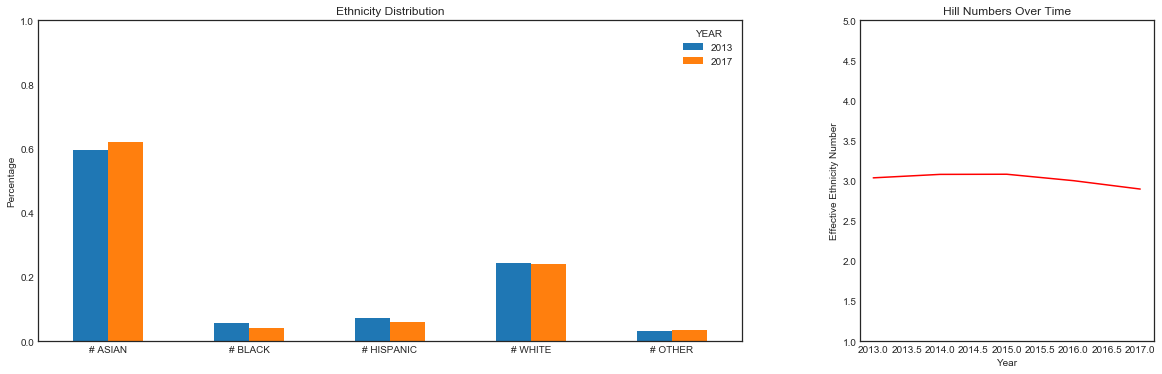

# Gender

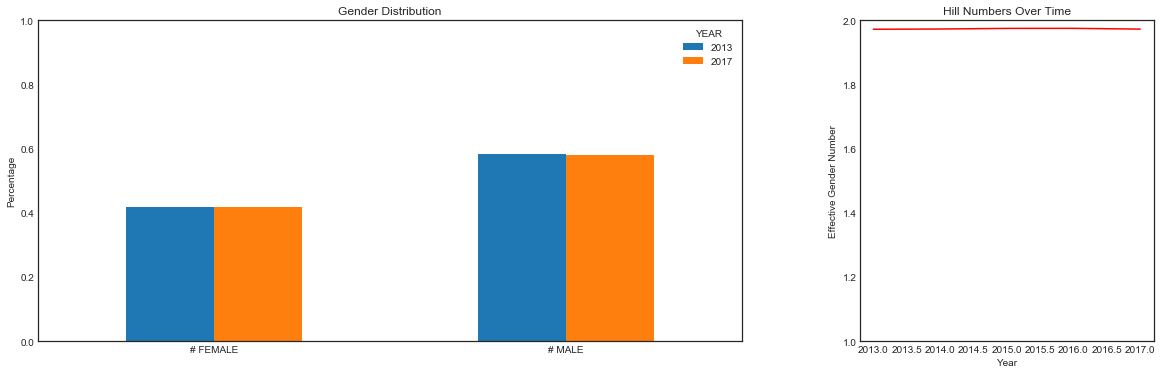

# Disabilities

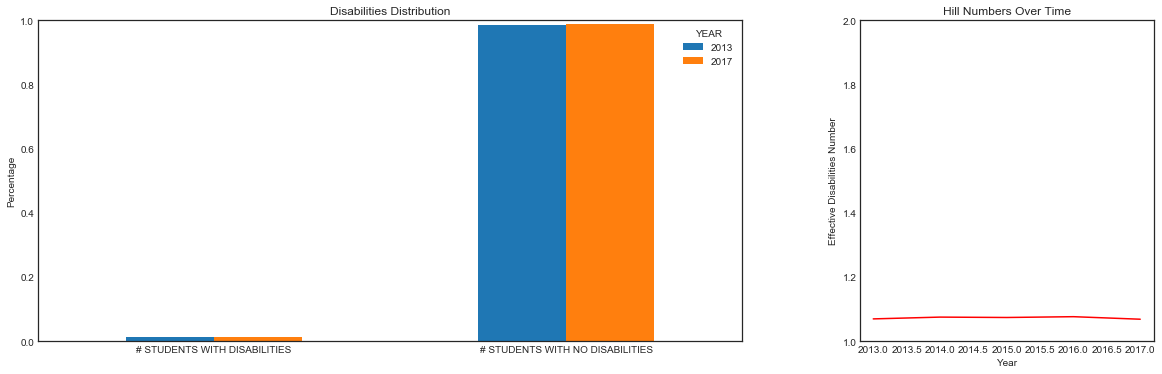

# Poverty

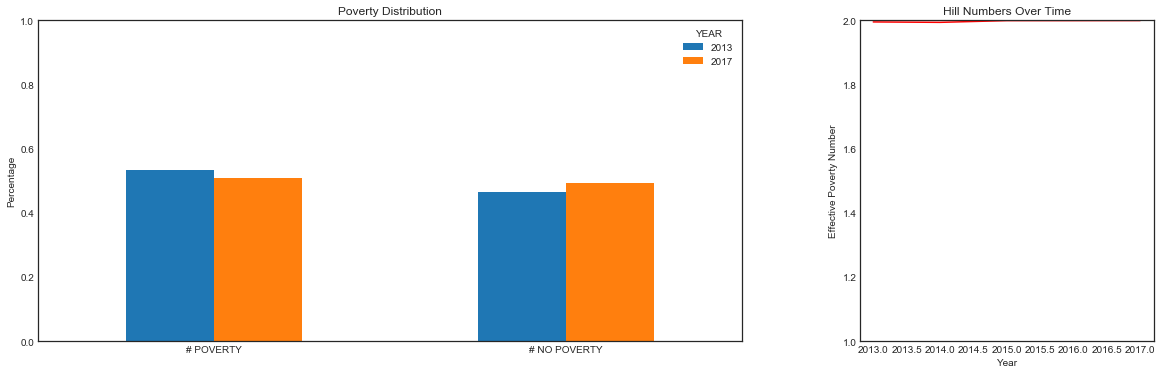

# English Language Learners

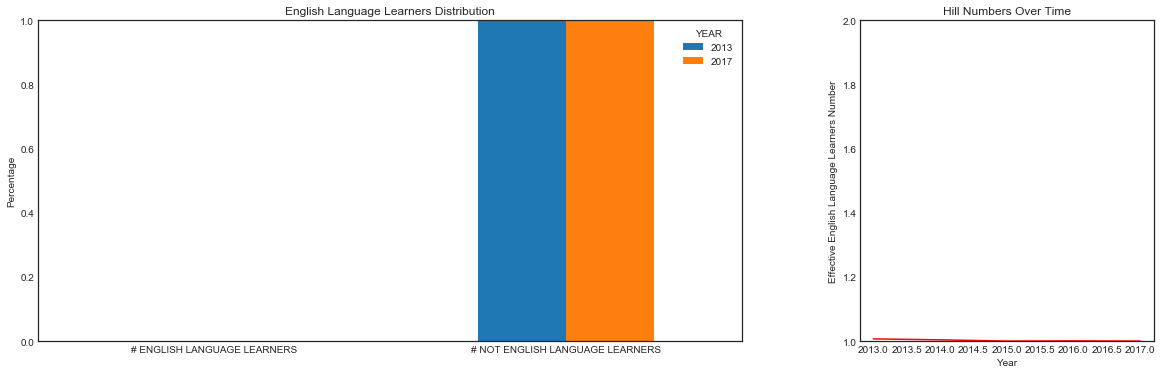

In [28]:
def log(n: float) -> float:
    """
    Allows math.log to return 0 for log(0) instead of undefined for the purpose of calculating a Shannon Index.
    """
    if n==0:
        return 0
    else:
        return math.log(n)
    
    
def shannon_index(categories: List[int]) -> Tuple[float, float, int]: 
    """
    Calculates Shannon Index numbers for a demographic list.
    
    Args:
        categories (List[int]): A list of demographic categories.

    Returns:
        Tuple[float, float, int]: (Shannon Index expected value, Shannon Index variance, total number of observations)
    """
    N = sum(categories)
    expected_value = -sum((x/N)*log(x/N) for x in categories)
    variance = ((sum((x/N)*(log(x/N)**2) for x in categories) - ((sum((x/N)*log(x/N) for x in categories))**2))/N) + ((len(categories)-1)/(2*(N**2)))
    return (expected_value, variance, N)


def shannon_list(date_range: Tuple[int, int], demographic_list: List[str], demographic_df: pd.DataFrame) -> List[Union[float, str]]:
    """
    Creates a list of the yearly overall Shannon Index information for the specialized high schools.
    
    Args:
        date_range (Tuple[int,int]): The year range of demographic data to include.
        demographic_list (List[str]): A list of demographic categories.
        demographic_df (pd.DataFrame): A pandas dataframe of demographic values.

    Returns:
        List[int, float, float, int]: A list of school year, Shannon expected value, Shannon variance, 
                                      and total number of observations as the value.
    """
    shannon = []
    for year in range(date_range[0], date_range[1]+1):
        shannon.append([year, *shannon_index(list(demographic_df.xs(year, level='YEAR')[[' '.join(['#', demographic]) for demographic in demographic_list]].sum().values))])
    return shannon


def hill_graphs(date_range: Tuple[int, int], demographic_list: List[str], demographic_name: str, demographic_df: pd.DataFrame) -> None:
    """
    Creates a set of bar charts and lineplots visualizing the change in diversity for a date range
    
    Args:
        date_range (Tuple[int,int]): The year range of demographic data to include.
        demographic_list (List[str]): A list of demographic categories.
        demographic_name (str): The name of the demographic to be included in graph text.
        demographic_df (pd.DataFrame): A pandas dataframe of demographic values.

    Returns:
        None: Multiple graphs.
    """
    shannon = shannon_list(date_range, demographic_list, demographic_df)
    
    fig = plt.figure(figsize=(20, 8*(len(specialized_dict)+1)))
    grid = plt.GridSpec(len(specialized_dict)+1, 3, hspace=0.4, wspace=0.4)

    barcharts = fig.add_subplot(grid[i,:2])
    barcharts.set_ylabel('Percentage')
    barcharts.set_ylim(0,1)
    barcharts.set_title(demographic_name + ' Distribution')
    
    demographic_df.query('YEAR in @date_range')[[' '.join(['#', demographic]) for demographic in demographic_list]]\
                   .groupby(level=1).sum().apply(lambda x: x/x.sum(), axis=1)\
                   .sort_index().T\
                   .plot(kind='bar', ax=barcharts, rot=0)


    lineplots = fig.add_subplot(grid[i,2:])
    lineplots.set_ylabel('Effective ' + demographic_name + ' Number')
    lineplots.set_xlabel('Year')
    lineplots.set_ylim(1, len(demographic_list))
    lineplots.set_title('Hill Numbers Over Time')



    lineplots.plot(*zip(*[[x[0], math.exp(x[1])] for x in shannon]), color="red")

    
    
    plt.show(fig);

    
for i, demographic in enumerate(demographic_dict.keys()):
    display(Markdown('# {}'.format(demographic)))
    hill_graphs(years, demographic_dict[demographic], demographic, specialized_df);

Some observations about the visualizations:

**Ethnicity**:
* The multiple ethnicities not represented have increased in overall frequency since 2013. They've noticingly become more present at the High School for Mathematics, Science, and Engineering at City College (HSMSE) and The Brooklyn Latin School, where both have "other" ethnicities make up more than 10% of their student body. 
* The proportion of Hispanic and black students has gone down in seven of the eight specialized high schools. 
* The proportion of Asian and white students has gone up in most high schools. 

**Gender**:
* Since 2013, half of the high schools have increased in female proportion and half of the high schools have decreased in female proportion.
* Overall, the proportions have changed less than a tenth of a percent.

**Disability**:
* Most high schools maintained a low number of students of disabilities, either increasing or decreasing by a relatively small amount. 
* High School for Mathematics, Science, and Engineering at City College (HSMSE) went from about 3.1% of its students having disabilities in 2013/2014 to 4.8% in 2017/2018.

**Poverty**:
* Overall, the percentage of students with poverty has gone down from 53.3% to 50.7%. Since this is closer to 50/50 though, the diversity has technically increased. If this trend continues, the diversity will start dropping once the proportion of students with poverty drops below 50%.
* The proportion of students with poverty has gone down in every high school except for one. 
* The high school where the proportion of students with poverty increased was Staten Island Technical High School, where it went from 31.7% to 40.8%. 

**English Language Learners**
* In 2013, 5 of the high schools had students who were English Language Learners. By 2017, only the High School for Mathematics, Science and Engineering at City College (HSMSE) did.

## Hypothesis testing

Seeing the diversity visualized gives some initial details of how demographics have changed over the years. However, since some of the changes are subtle, it would be helpful if there was a way to see if any changes were statistically significant. One way to compare diversity is to use Hutcheson's t-test. <sup><a href='#11'>11</a> , <a href='#12'>12</a></sup> Created by Kermit Hutcheson in a letter to the editor in a 1970 issue of the Journal of Theoretical Biology, Hutcheson's t-test is an unpooled two-sample t-test specifically adapted for Shannon Indices.

For this test, the null and alternative hypotheses are \\(H_0: H_a = H_b\\) and \\(H_1: H_a \ne H_b\\) respectively, with \\(H_a\\) and \\(H_b\\) being the two Shannon Indices. The null hypothesis assumes equal diversity in the two samples. The test statistic is calculated as
$$ t = \frac{H_a - H_b}{\sqrt{s^{2}_{H_a} + s^{2}_{H_b}}} $$

with \\(s^{2}_{H}\\) being the sample variance of the Shannon Index. The degrees of freedom are given by

$$ \frac{\big(s^{2}_{H_a} + s^{2}_{H_b}\big)^2}
{\Bigg(\frac{\big(s^{2}_{H_a}\big)^2}{N_a} + \frac{\big(s^{2}_{H_b}\big)^2}{N_b}\Bigg)} $$

There will be five hypotheses tests ran: one for each demographic (ethnicity, gender, disability, poverty, English Language Learner). Each demographic will be tested on the specialized schools grouped together instead of individually. This will allow fewer hypotheses tests and answers the question at hand: have specialized schools become less diverse over the years. 

Since multiple tests are being conducted, the False Discovery Rate (the proportion of false rejections of the null hypothesis compared to the total number of rejections) will be controlled using the Benjamini-Hochberg procedure. <sup><a href='#13'>13</a></sup>

In [29]:
def t_test(a: float, var_a: float, N_a: int, b: float, var_b: float, N_b: int) -> Tuple[float, int, float]:
    """
    Calculates the Hutcheson t-test statistics to compare two Shannon Indices
    
    Args:
        a (float): Shannon Index #1
        var_a (float): Shannon Index #1 variance
        N_a (float): total observations #1
        b (float): Shannon Index #2
        var_b (float): Shannon Index #2 variance
        N_b: total observations #2

    Returns:
        Tuple[float, int, float]: A tuple of (t-statistic, degrees of freedom, p-value)
    """
    t = (a - b)/math.sqrt(var_a + var_b)
    df = math.ceil(((var_a + var_b)**2)/(((var_a**2)/N_a)+((var_b**2)/N_b)))
    return (t, df, 1 - scipy.stats.t.cdf(math.fabs(t), df))

def shannon_t_tests(date_range: Tuple[int, int]) -> pd.DataFrame:
    """
    Creates table displaying multiple t-tests adjusted with the Benjamini-Hochberg procedure
    
    Args:
        date_range (Tuple[int,int]): The year range of demographic data to include.
        
    Returns:
        None: A pandas dataframe.
    """
    significance_df = pd.DataFrame(data=None, columns = ['Name', "Shannon Index " + str(date_range[0]), "Shannon Index " + str(date_range[1]), 't', 'df', 'pval'])
    for i, demographic in enumerate(demographic_dict.keys()):
        shannon = shannon_list(date_range, demographic_dict[demographic], specialized_df)
        significance_df.loc[i] = (demographic, shannon[0][1], shannon[-1][1], *t_test(*shannon[0][1:],*shannon[-1][1:]))
    is_reject, corrected_pvals, _, _ = multipletests(significance_df["pval"], alpha=0.05, method='fdr_bh')
    significance_df["reject"] = is_reject
    significance_df["adj_pval"] = corrected_pvals
    return significance_df

In [30]:
shannon_t_tests(years)

,Name,Shannon Index 2013,Shannon Index 2017,t,df,pval,reject,adj_pval
0,Ethnicity,1.111196,1.064074,4.673599,30412,0.000001,True,0.000007
1,Gender,0.679389,0.679625,-0.125445,30330,0.450086,False,0.450086
2,Disabilities,0.067505,0.066563,0.169228,30346,0.432809,False,0.450086
3,Poverty,0.690904,0.693036,-3.770782,16485,0.000082,True,0.000204
4,English Language Learners,0.007499,0.000685,3.663771,18587,0.000125,True,0.000208


After adjusting for multiple tests, the null hypotheses for ethnicity, poverty, and English Language Learners are rejected at a rejection level of \\(\alpha=0.05\\). Therefore, there is evidence that the diversity of these demographics in specialized high schools between the 2013/2014 school year and the 2017/2018 school year is not equal. In the cases of ethnicity and English Language Learners, it appears that the diversity has decreased. With poverty, it appears that the diversity has actually increased. 

Looking at the visualizations of the data again, this makes some sense. 

* Ethnicity appears not to have changed too much, but since the total enrollment of students in specialized high schools is 14,876 in the 2013/2014 school year and 15,540 in the 2017/2018, the variance is lower. Even a small change is significant.

In [31]:
for year in years:
    print('Total enrollment in {}: {}'.format(year, specialized_df.query('YEAR==@year')['TOTAL ENROLLMENT'].sum()))

Total enrollment in 2013: 14876
Total enrollment in 2017: 15540


* Both gender and disability seem to have not changed at all, so it is not surprising that the difference in their proportions was not big enough to warrant a rejection of the null hypothesis. 
* The proportion of students with poverty at the specialized high schools shifted by +/- 2.5. Since the proportions converged near 50%, the diversity is near it's maximum Hill Number value. 
* The English Language Learner percentages in 2013 and 2017 look nearly identical, but since there were 14 students who were English Language Learners in 2013 and only 1 in 2017, it decreased significantly. 

In [32]:
for year in years:
    print('Total English Language Learner enrollment in {}: {}'.format(year, specialized_df.query('YEAR==@year')['# ENGLISH LANGUAGE LEARNERS'].sum()))

Total English Language Learner enrollment in 2013: 14
Total English Language Learner enrollment in 2017: 1


In retrospect, it may be difficult to quantify students as English Language Learners. Since one of the two components of the SHSAT is English Language Arts<sup>1</sup>,  a student needs to be adept at the English language to score well. If a student scores well enough to pass, they might not consider themselves an English Language Learner. 

With that being said, the only quantifiable demographic that has gone down in diversity in the specialized high schools is ethnicity. In regards to ethnicity, PASSNYC is correct in saying that the student bodies have become more homogeneous over the past few years. The second part of this project will aim to find ways to fix that. 

# Bibliography

<br/>
<br/>
<a id='1'> 1. </a> <a href='https://www.kaggle.com/new-york-city/nyc-high-school-directory/home'> "NYC High School Directory" on Kaggle</a><br/>

<a id='2'> 2. </a> <a href='https://laguardiahs.org/apps/pages/index.jsp?uREC_ID=314119&type=d'>Fiorello H. LaGuardia High School Website</a><br/>

<a id='3'> 3. </a> <a href='https://www.princetonreview.com/k12/shsat-information'>SHSAT Information from The Princeton Review</a><br/>

<a id='4'> 4. </a> <a href='http://www.passnyc.org/'>PASSNYC Website</a><br/>

<a id='5'> 5. </a> <a href='https://data.cityofnewyork.us/Education/2013-2018-Demographic-Snapshot-School/s52a-8aq6'> "2013-2018 Demographic Snapshot School" on NYC Open Data</a><br/>

<a id='6'> 6. </a> <a href='https://en.wikipedia.org/wiki/Diversity_index#Simpson_index'> Wikipedia article on diversity indices </a><br/>

<a id='7'> 7. </a> <a href='http://eebweb.arizona.edu/courses/Ecol206/shannon%20weaver-wiener.pdf'> Ian F. Spellerberg and Peter J. Fedor "A tribute to Claude Shannon (1916–2001) and a plea for
more rigorous use of species richness, species diversity
and the ‘Shannon–Wiener’ Index", 2003 </a><br/>

<a id='8'> 8. </a> <a href='http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf'>Claude Shannon "A Mathematical Theory of Communication", 1948 </a><br/>

<a id='9'> 9. </a> <a href='https://www.uvm.edu/~ngotelli/manuscriptpdfs/ChaoHill.pdf'>Anne Chao "Rarefaction and extrapolation with Hill numbers: a framework
for sampling and estimation in species diversity studies", 2014</a><br/>

<a id='10'> 10. </a> <a href='http://www.loujost.com/Statistics%20and%20Physics/Diversity%20and%20Similarity/EffectiveNumberOfSpecies.htm'>Lou Jost on "Effective Number of Species"</a><br/>

<a id='11'> 11. </a> <a href='https://www.sciencedirect.com/science/article/pii/0022519370901244'>Kermit Hutcheson "A test for comparing diversities based on the shannon formula", 1970 </a><br/>

<a id='12'> 12. </a> <a href='http://www.dataanalytics.org.uk/Publications/S4E2e%20Support/exercises/Comparing%20shannon%20diversity.htm'>Post by Mark Gardener on DataAnalytics.org.uk about calculating the Hutcheson's t-test</a><br/>

<a id='13'> 13. </a> <a href='https://multithreaded.stitchfix.com/blog/2015/10/15/multiple-hypothesis-testing/'>More reading about Benjamini</a><br/>